In [17]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import multivariatet as mt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

%matplotlib inline

In [18]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

full_X = mnist[mnist.columns[1:]].values / 255
full_y = mnist.label.values

X = full_X[:1000]
y = full_y[:1000]

n,d = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
domain = (1/784) * np.asarray([.125,.25,.5,1,2,4,8,16,32,64,128])

In [42]:
def generate_kernel(m=350, s=1/d):
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m))
    #W = mt.multivariate_t.rvs(mean=np.zeros(d), df=1, shape=2*s*np.eye(d), size=m) # m x d
    value = np.sqrt(2s)
    W = np.random.uniform(low=-value, high=value, size=(m,d))
    def ker(x, y):
        z1 = np.cos(x @ W.T + b)
        z2 = np.cos(y @ W.T + b)
        return z1 @ z2.T / m
    return ker

In [48]:
iterations = 10
scores = np.empty((domain.shape[0], iterations))
    
for i,val in enumerate(domain):
    for j in range(iterations):
        random_svm = SVC(kernel=generate_kernel(s=val))
        random_svm.fit(X_train, y_train)
        scores[i,j] = random_svm.score(X_test, y_test)

stat = np.empty((7, domain.shape[0]))
stat[0] = np.min(scores, axis=1)
stat[1] = np.quantile(scores, 0.25, axis=1)
stat[2] = np.median(scores, axis=1)
stat[3] = np.quantile(scores, 0.75, axis=1)
stat[4] = np.max(scores, axis=1)
stat[5] = np.mean(scores, axis=1)
stat[6] = np.std(scores, axis=1)

Text(0.5, 1.0, "Randomized Kernel SVM accuracy 'continuous boxplot'")

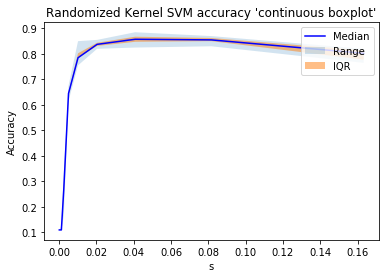

In [49]:
plt.plot(domain, stat[2], c='b', label='Median')
plt.fill_between(domain, stat[4], stat[0], alpha=0.2, label='Range', lw=1)
plt.fill_between(domain, stat[1], stat[3], alpha=0.5, label='IQR', lw=1)
plt.xlabel('s')
plt.ylabel('Accuracy')
#plt.set_yscale('log')
plt.legend(loc='upper right')
plt.title('Randomized Kernel SVM accuracy \'continuous boxplot\'')

In [45]:
large_X = full_X[:10000]
large_y = full_y[:10000]
large_X_train, large_X_test, large_y_train, large_y_test = train_test_split(large_X, large_y, test_size=0.2, random_state=15)

In [46]:
start = perf_counter()
svm = SVC(gamma='auto')
svm.fit(large_X_train, large_y_train)
det_score = svm.score(large_X_test, large_y_test)
end = perf_counter()
det_time = end - start


iterations = 100
scores = np.empty(iterations)
times = np.empty(iterations)

for i in tqdm(range(iterations)):
    start = perf_counter()
    random_svm = SVC(kernel=generate_kernel())
    random_svm.fit(large_X_train, large_y_train)
    end = perf_counter()
    times[i] = end - start
    scores[i] = random_svm.score(large_X_test, large_y_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:10<00:00,  4.30s/it]


In [47]:
print(f'Gaussian kernel: Accuracy: {det_score}, time: {det_time}')
print(f'Random kernel: Mean accuracy: {np.mean(scores)}, stdev: {np.std(scores)}, mean time: {np.mean(times)}')
print(f'Acc. stats: Q0: {np.min(scores)}, Q1: {np.quantile(scores, 0.25)}, Q2: {np.median(scores)}, Q3: {np.quantile(scores,0.75)}, Q4: {np.max(scores)}')

Gaussian kernel: Accuracy: 0.9195, time: 55.315938899999765
Random kernel: Mean accuracy: 0.8218049999999998, stdev: 0.007699641225407836, mean time: 3.3171135520000323
Acc. stats: Q0: 0.8035, Q1: 0.8165, Q2: 0.8225, Q3: 0.8265, Q4: 0.8425
